
### T1 Data Analysis  

        Sean Keenan, PhD Physics  
        Quantum Memories Group, Heriot-Watt University, Edinburgh  
        2021  

In [1]:
import data_funcs as df
from filter_funcs import smooth_data
from fit_funcs import peak_find
from math_funcs import bin_data, ODset_calc
import matplotlib.pyplot as mp
import numpy as np
import plotting_funcs as plt
import os

mp.style.use('signature.mplstyle')

path = r"C:\Users\Keena\Desktop\0329_Fluor_duration"

In [2]:
folder_list, file_list = df.dir_interogate(path, extensions=('.csv', '.txt'))
path_names = df.read_files(folder_list, file_list)
selected_files = [df.search_paths(paths, keys=('.txt',)) for paths in path_names]
info_paths = [text_file for columns in selected_files for text_file in columns[0]]
excel_paths = [column[1] for column in selected_files]
info_files = [df.open_text(os.path.join(path, file_path)) for file_path in info_paths]
excel_folders = [[df.open_excel(os.path.join(path, file_path)) for file_path in excel_file_paths] for excel_file_paths in excel_paths]

AttributeError: module 'data_funcs' has no attribute 'read_files'


##### Import Data  
        
        Load data sets & extract time and voltage data


In [ ]:
time_data_sets = [[excel_file[0] for excel_file in excel_folder] for excel_folder in excel_folders]
trigger_data_sets = [[excel_file[1] for excel_file in excel_folder] for excel_folder in excel_folders]
transmitted_data_sets = [[excel_file[2] for excel_file in excel_folder] for excel_folder in excel_folders]
reference_data_sets = [[excel_file[3] for excel_file in excel_folder] for excel_folder in excel_folders]
times = [x *1E6 for x in time_data_sets[0][0]]
fluor_duration = [[float(sf.find_numbers(row)) for row in text_file if sf.check_str(["durationFluor"], row.split())] for text_file in info_files] # type: ignore


##### Check channel assignment  

        Plot one of each channel to check assignment is correct for calculations


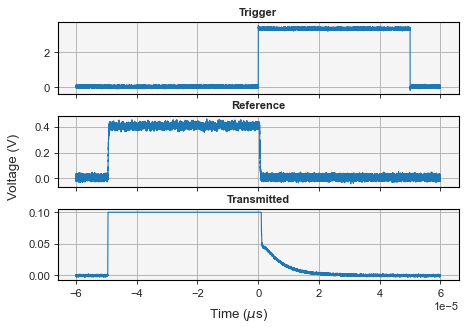

In [ ]:
fig, ax = mp.subplots(nrows=3, ncols=1, sharex='all')
# shared labels
fig.tight_layout(w_pad=2, rect=[0.05, 0.05, 1, 1])
fig.supxlabel('Time ($\mu$s)')
fig.supylabel('Voltage (V)')

ax[0].set_title('Trigger')
ax[0].plot(time_data_sets[0][0], trigger_data_sets[0][0])
ax[1].set_title('Reference')
ax[1].plot(time_data_sets[0][0], reference_data_sets[0][0])
ax[2].set_title('Transmitted')
ax[2].plot(time_data_sets[0][0], transmitted_data_sets[0][0])


##### Fine Tune Trigger Point

        Check the trigger index and adjust if neccesary
        

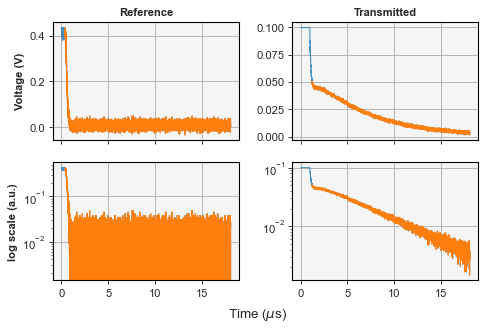

In [ ]:
# find the trigger indexes
trig_indexes = [[sf.find_trigger(trigger_data, modifier=0.989) for trigger_data in trigger_list] for trigger_list in trigger_data_sets]
# plot small portion to check ramp off on transmitted data
ramp_off = 15000 + trig_indexes[0][0]
# pick an offset
ref_offset = 300
offset = 1000
# plot the transmitted data from trigger point and compare with the offset 
fig, ax = mp.subplots(ncols=2, nrows=2, sharex=True)
# shared labels
fig.tight_layout(w_pad=2, rect=[0, 0.05, 1, 1])
fig.supxlabel('Time ($\mu$s)')
# plot on separate subplots
ax[0][0].set_title('Reference')
ax[0][0].plot(times[trig_indexes[0][0]:ramp_off], reference_data_sets[0][0][trig_indexes[0][0]:ramp_off], label='raw', alpha=0.8)
ax[0][0].plot(times[trig_indexes[0][0]+ref_offset:ramp_off], reference_data_sets[0][0][trig_indexes[0][0]+ref_offset:ramp_off], label='cut')
ax[0][0].set(ylabel='Voltage (V)')

ax[0][1].set_title('Transmitted')
ax[0][1].plot(times[trig_indexes[0][0]:ramp_off], transmitted_data_sets[0][0][trig_indexes[0][0]:ramp_off], label='raw', alpha=0.8)
ax[0][1].plot(times[trig_indexes[0][0]+offset:ramp_off], transmitted_data_sets[0][0][trig_indexes[0][0]+offset:ramp_off], label='cut')

ax[1][0].plot(times[trig_indexes[0][0]:ramp_off], reference_data_sets[0][0][trig_indexes[0][0]:ramp_off], label='raw', alpha=0.8)
ax[1][0].plot(times[trig_indexes[0][0]+ref_offset:ramp_off], reference_data_sets[0][0][trig_indexes[0][0]+ref_offset:ramp_off], label='cut')
ax[1][0].set(ylabel='log scale (a.u.)')
ax[1][0].set_yscale('log')

ax[1][1].plot(times[trig_indexes[0][0]:ramp_off], transmitted_data_sets[0][0][trig_indexes[0][0]:ramp_off], label='raw', alpha=0.8)
ax[1][1].plot(times[trig_indexes[0][0]+offset:ramp_off], transmitted_data_sets[0][0][trig_indexes[0][0]+offset:ramp_off], label='cut')
ax[1][1].set_yscale('log')


##### Process Data  

        Remove negatives and create smoothed and normalised sets


In [ ]:
# initial guess for the decay times (us)
guess_ref_T1 = 1E-6
guess_T1 = 10E-6
# shorten data for fitting by finding last index of useful data
ref_stop_indexes = [[round(guess_ref_T1*5 / (time[1] - time[0])) for time in time_lists] for time_lists in time_data_sets]
stop_indexes = [[round(guess_T1*4  / (time[1] - time[0])) for time in time_lists] for time_lists in time_data_sets]
# generate new list of trigger indexes plus the offset
new_trig_indexes = [[value + offset for value in trig_index] for trig_index in trig_indexes]
ref_trig_indexes = [[value + ref_offset for value in trig_index] for trig_index in trig_indexes]
# trim the data sets to only contain data from the trigger onward to the end of useful data index
time_cut_data_sets = [[time[start:start+stop] for time, start, stop in zip(time_set, start_set, stop_set)] for time_set, start_set, stop_set in zip(time_data_sets, new_trig_indexes, stop_indexes)]
ref_cut_time_data_sets = [[ref_time[start:start+stop] for ref_time, start, stop in zip(ref_time_set, start_set, stop_set)] for ref_time_set, start_set, stop_set in zip(time_data_sets, ref_trig_indexes, stop_indexes)]
trans_cut_data_sets = [[trans[start:start+stop] for trans, start, stop in zip(trans_set, start_set, stop_set)] for trans_set, start_set, stop_set in zip(transmitted_data_sets, new_trig_indexes, stop_indexes)]
ref_cut_data_sets = [[ref[start:start+stop] for ref, start, stop in zip(ref_set, start_set, stop_set)] for ref_set, start_set, stop_set in zip(reference_data_sets, ref_trig_indexes, stop_indexes)]
# find max and min values in transmitted data for list comprehension
list_of_mins = [[min(trans_list) for trans_list in transmitted_lists] for transmitted_lists in transmitted_data_sets]
list_of_maxs = [[max(trans_cut_list) for trans_cut_list in trans_cut_lists] for trans_cut_lists in trans_cut_data_sets]
ref_min_list = [[min(ref_list) for ref_list in reference_lists] for reference_lists in reference_data_sets]
ref_max_list = [[max(ref_list) for ref_list in ref_cut_lists] for ref_cut_lists in ref_cut_data_sets]
# create a boxcar window and then create a list of smoothed data
avg_window = moving_av(10)
length_avg_window = avg_window.shape[0] // 2
# create lists of smoothed, corrected, smoothed and corrected
ref_corrected = [[sf.zero_data(ref_list) for ref_list in reference_lists] for reference_lists in ref_cut_data_sets]
trans_smoothed = [[fftconvolve(avg_window, trans_cut_list)[length_avg_window-1:-length_avg_window] for trans_cut_list in trans_cut_lists] for trans_cut_lists in trans_cut_data_sets]
trans_corrected = [[sf.zero_data(trans_list) for trans_list in transmitted_lists] for transmitted_lists in trans_cut_data_sets]
trans_avg_cor = [[sf.zero_data(smoothed_list) for smoothed_list in smoothed_lists] for smoothed_lists in trans_smoothed]


##### Fit to Reference Detector Data
        Determine Fall Time

Fit Params data[0]:
I0 : 4627866.22 mV, T1 : 0.18 us, Y0 : 48764.91 mV
Fit Error data[0]:
dI0 : 65176.57 mV, dT1 : 0.001 us, dY0 : 63.06 mV 

Fit Params data[1]:
I0 : 4715095.34 mV, T1 : 0.18 us, Y0 : 38438.62 mV
Fit Error data[1]:
dI0 : 64689.24 mV, dT1 : 0.001 us, dY0 : 63.42 mV 

Fit Params data[2]:
I0 : 4909229.62 mV, T1 : 0.18 us, Y0 : 45227.06 mV
Fit Error data[2]:
dI0 : 59615.45 mV, dT1 : 0.001 us, dY0 : 65.70 mV 

Fit Params data[3]:
I0 : 5649702.51 mV, T1 : 0.18 us, Y0 : 41230.62 mV
Fit Error data[3]:
dI0 : 62250.97 mV, dT1 : 0.001 us, dY0 : 65.28 mV 

Fit Params data[4]:
I0 : 6437761.39 mV, T1 : 0.18 us, Y0 : 41554.49 mV
Fit Error data[4]:
dI0 : 60583.83 mV, dT1 : 0.001 us, dY0 : 68.99 mV 

Fit Params data[5]:
I0 : 7096907.42 mV, T1 : 0.18 us, Y0 : 41323.75 mV
Fit Error data[5]:
dI0 : 64181.30 mV, dT1 : 0.001 us, dY0 : 69.42 mV 

Fit Params data[6]:
I0 : 7871973.38 mV, T1 : 0.18 us, Y0 : 48960.29 mV
Fit Error data[6]:
dI0 : 68402.99 mV, dT1 : 0.001 us, dY0 : 70.10 mV 

Fit Pa

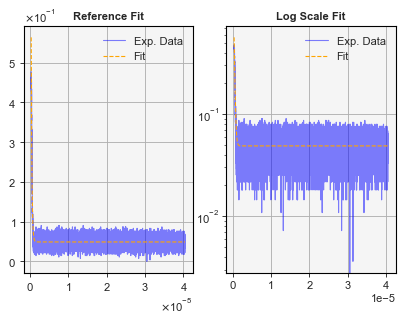

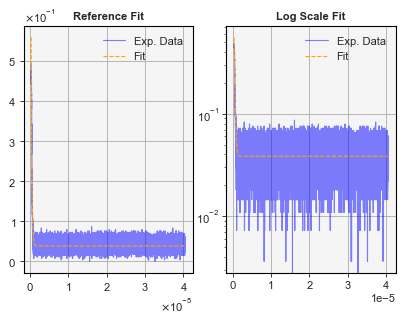

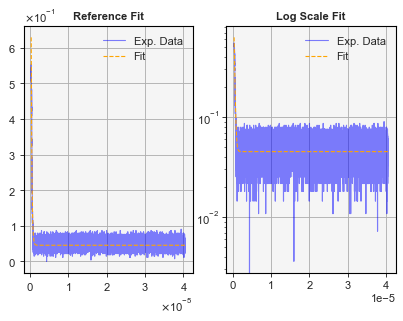

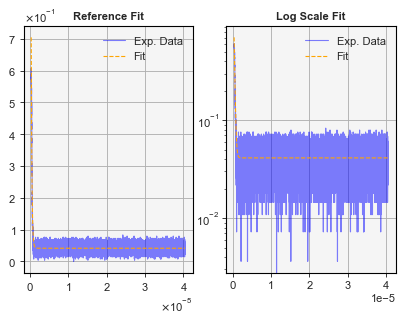

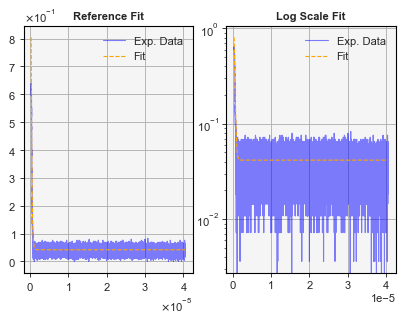

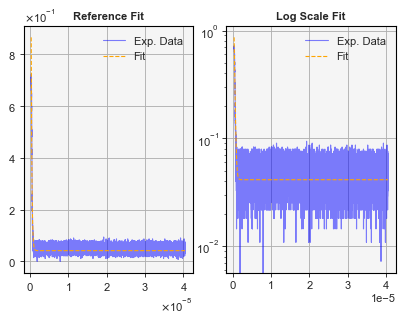

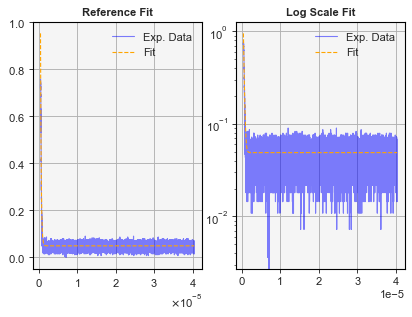

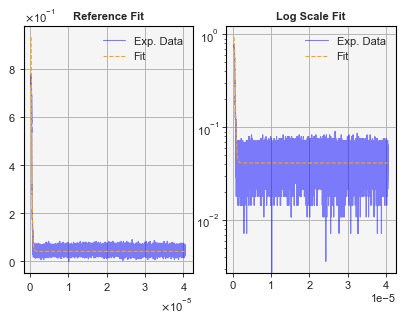

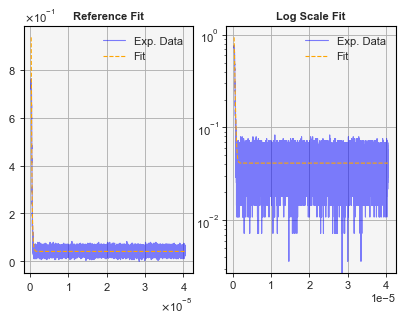

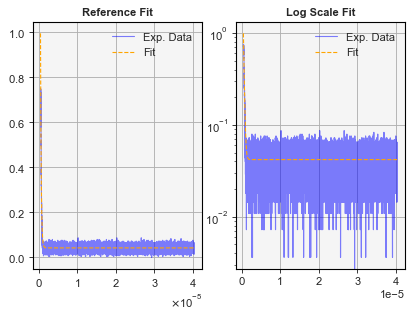

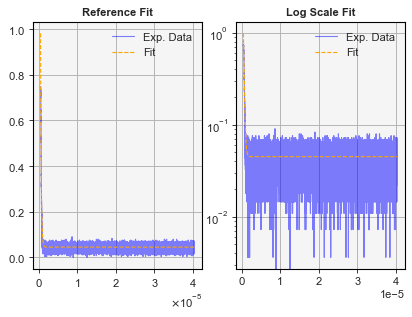

In [ ]:
ref_zipped = zip(ref_cut_time_data_sets, ref_corrected, ref_max_list, ref_min_list)
reference_fit_sets = [[ff.fit_exp_decay(time, ref, params=(max_value, guess_ref_T1, min_value)) for time, ref, max_value, min_value in zip(time_set, ref_set, max_set, min_set)] for time_set, ref_set, max_set, min_set in ref_zipped]

# loop over references - fit and plot data of one set per folder
for idx, ref_fitted_set in enumerate(reference_fit_sets):

    fig, ax = mp.subplots(nrows=1, ncols=2)
    
    ax[0].set_title('Reference Fit')
    ax[0].plot(ref_cut_time_data_sets[idx][0], ref_corrected[idx][0], color='blue', alpha=0.5, label='Exp. Data')
    ax[0].plot(ref_cut_time_data_sets[idx][0], ff.exp_decay(np.array(ref_cut_time_data_sets[idx][0]), *ref_fitted_set[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText = True)
    ax[0].legend()

    ax[1].set_title('Log Scale Fit')
    ax[1].plot(ref_cut_time_data_sets[idx][0], ref_corrected[idx][0], color='blue', alpha=0.5, label='Exp. Data')
    ax[1].plot(ref_cut_time_data_sets[idx][0], ff.exp_decay(np.array(ref_cut_time_data_sets[idx][0]), *ref_fitted_set[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[1].set_yscale('log')
    ax[1].legend()

    # print out fitted values
    print('Fit Params data[{0}]:'.format(idx))
    print("I0 : {0:2.2f} mV, T1 : {1:2.2f} us, Y0 : {2:2.2f} mV".format(*ref_fitted_set[idx][0]*1E6))
    print('Fit Error data[{0}]:'.format(idx))
    print("dI0 : {0:2.2f} mV, dT1 : {1:2.3f} us, dY0 : {2:2.2f} mV \n".format(*ref_fitted_set[idx][1]*1E6))

ref_fall_times = [[T1[0][1] for T1 in reference_fitted] for reference_fitted in reference_fit_sets]


##### Fit To Corrected Data

        Fit to exponential decay and return array of fit params and errors
      

c:\Users\keena\Documents\University\PhD\Code\Spectroscopy\.spec_venv\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Fit Params data[0]:
I0 : 61594.56 mV, T1 : 6.72 us, Y0 : 2398.43 mV
Fit Error data[0]:
dI0 : 35.01 mV, dT1 : 0.006 us, dY0 : 8.28 mV 

Fit Params data[1]:
I0 : 42422.29 mV, T1 : 7.43 us, Y0 : 1753.38 mV
Fit Error data[1]:
dI0 : 31.88 mV, dT1 : 0.010 us, dY0 : 8.91 mV 

Fit Params data[2]:
I0 : 37542.94 mV, T1 : 7.75 us, Y0 : 2186.95 mV
Fit Error data[2]:
dI0 : 30.92 mV, dT1 : 0.011 us, dY0 : 9.31 mV 

Fit Params data[3]:
I0 : 37607.20 mV, T1 : 7.71 us, Y0 : 1930.22 mV
Fit Error data[3]:
dI0 : 30.64 mV, dT1 : 0.011 us, dY0 : 9.12 mV 

Fit Params data[4]:
I0 : 38230.70 mV, T1 : 7.61 us, Y0 : 2016.56 mV
Fit Error data[4]:
dI0 : 31.61 mV, dT1 : 0.011 us, dY0 : 9.23 mV 

Fit Params data[5]:
I0 : 51215.27 mV, T1 : 6.91 us, Y0 : 2052.91 mV
Fit Error data[5]:
dI0 : 33.34 mV, dT1 : 0.007 us, dY0 : 8.26 mV 

Fit Params data[6]:
I0 : 50938.35 mV, T1 : 6.92 us, Y0 : 2025.19 mV
Fit Error data[6]:
dI0 : 33.83 mV, dT1 : 0.008 us, dY0 : 8.40 mV 

Fit Params data[7]:
I0 : 61520.90 mV, T1 : 6.52 us, Y0 

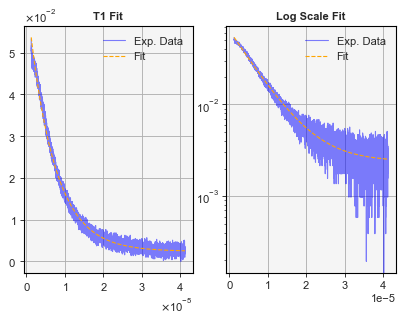

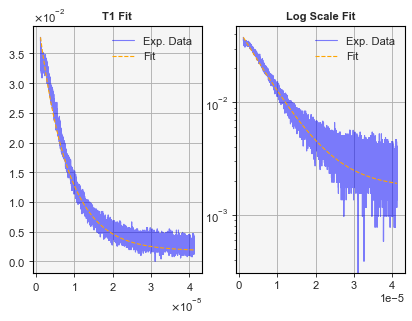

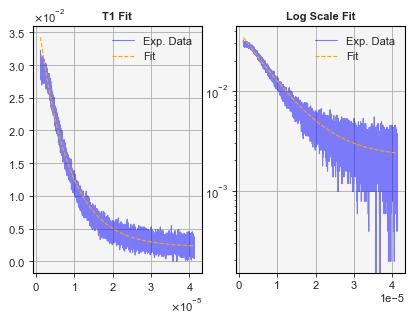

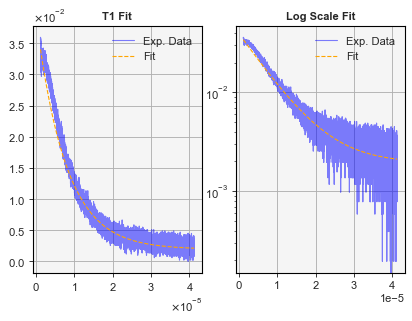

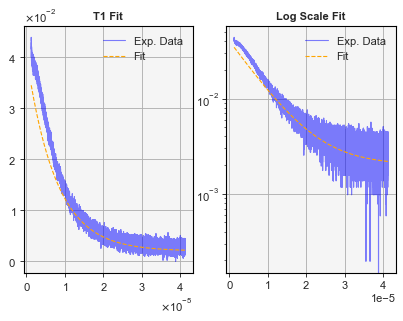

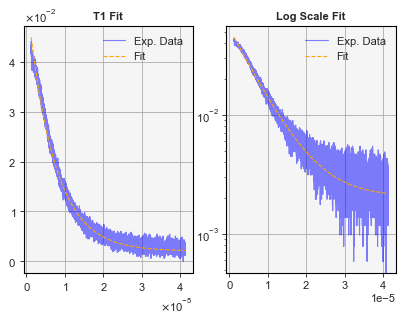

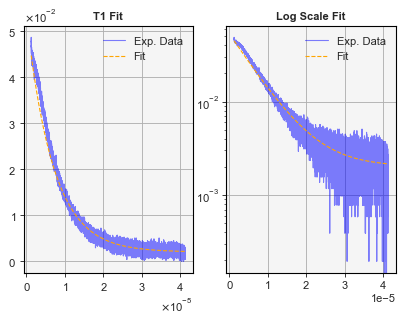

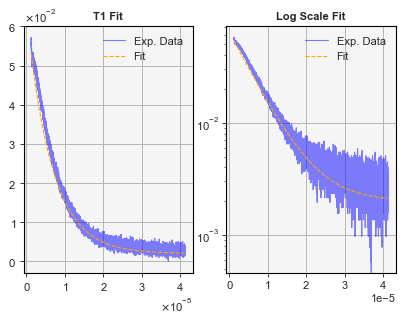

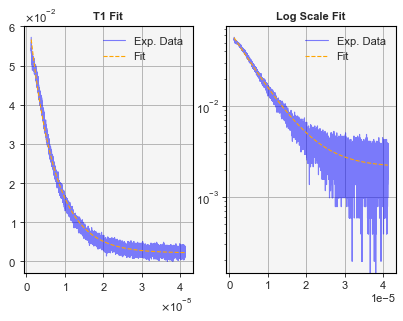

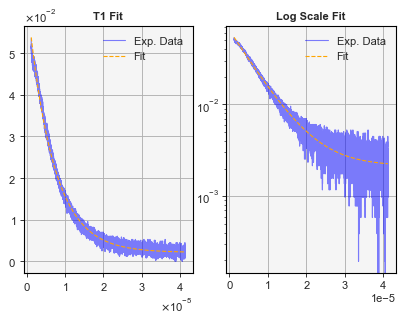

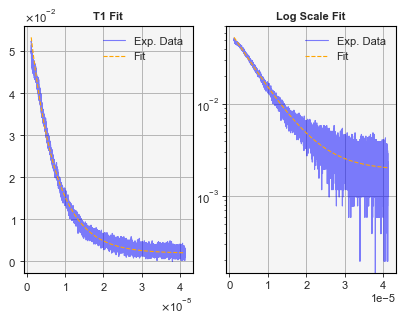

In [ ]:
zipped_sgl_data = zip(time_cut_data_sets, trans_corrected, list_of_maxs, list_of_mins)
fit_sgl_sets = [[ff.fit_exp_decay(time, trans, params=(0.3*max_val, guess_T1, min_val)) for time, trans, max_val, min_val in zip(time_set, trans_set, max_set, min_set)] for time_set, trans_set, max_set, min_set in zipped_sgl_data]
fit_data_sets = [[ff.exp_decay(np.array(time), *fit[0]) for time, fit in zip(time_set, fit_set)] for time_set, fit_set in zip(time_cut_data_sets, fit_sgl_sets)]

# loop over references - fit and plot data of one set per folder
for idx, fitted_set in enumerate(fit_sgl_sets):

    fig, ax = mp.subplots(nrows=1, ncols=2)
    
    ax[0].set_title('T1 Fit')
    ax[0].plot(time_cut_data_sets[idx][0], trans_corrected[idx][0], color='blue', alpha=0.5, label='Exp. Data')
    ax[0].plot(time_cut_data_sets[idx][0], ff.exp_decay(np.array(time_cut_data_sets[idx][0]), *fitted_set[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText = True)
    ax[0].legend()

    ax[1].set_title('Log Scale Fit')
    ax[1].plot(time_cut_data_sets[idx][0], trans_corrected[idx][0], color='blue', alpha=0.5, label='Exp. Data')
    ax[1].plot(time_cut_data_sets[idx][0], ff.exp_decay(np.array(time_cut_data_sets[idx][0]), *fitted_set[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[1].set_yscale('log')
    ax[1].legend()

    # print out fitted values
    print('Fit Params data[{0}]:'.format(idx))
    print("I0 : {0:2.2f} mV, T1 : {1:2.2f} us, Y0 : {2:2.2f} mV".format(*fitted_set[idx][0]*1E6))
    print('Fit Error data[{0}]:'.format(idx))
    print("dI0 : {0:2.2f} mV, dT1 : {1:2.3f} us, dY0 : {2:2.2f} mV \n".format(*fitted_set[idx][-1]*1E6))

T1_times = [[T1[0][1] for T1 in fitted] for fitted in fit_sgl_sets]
T1_binned = [sf.bin_data(T1_set, len(T1_set)//2) for T1_set in T1_times]

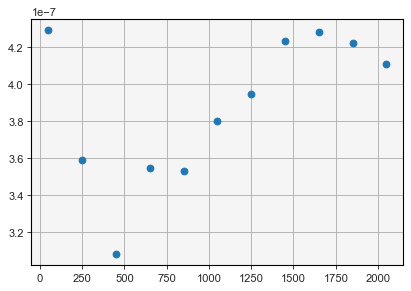

In [ ]:
T1_areas = [[simpson(T1_curve, time) for T1_curve, time in zip(T1_fits, times)] for T1_fits, times in zip(fit_data_sets, time_cut_data_sets)]
T1_area_avg = [sf.bin_data(areas, len(areas)//4) for areas in T1_areas]
fluor = [x * 1E6 for sublist in fluor_duration for x in sublist]
mp.plot(fluor, T1_area_avg, 'o')

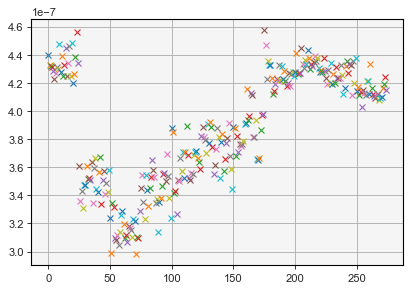

In [ ]:
count = 0
mp.figure()
for time_set, data_set in zip(time_cut_data_sets, trans_corrected):
    for times, datas in zip(time_set, data_set): 
        area = simpson(datas, times)
        mp.plot(count, area, 'x')
        count += 1

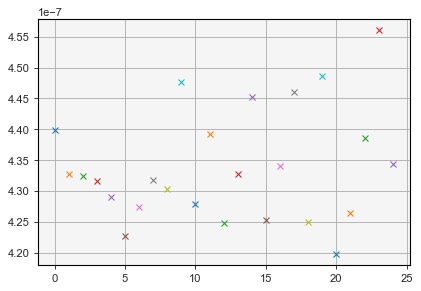

In [ ]:
from scipy.integrate import simpson
#area = 0
count = 0
mp.figure()

for times, datas in zip(time_cut_data_sets[0], trans_corrected[0]): 
    area = simpson(datas, times)
    mp.plot(count, area, 'x')
    count += 1

    


(array([2., 6., 7., 2., 3., 2., 2., 1.]),
 array([4.19763514e-07, 4.24306384e-07, 4.28849255e-07, 4.33392126e-07,
        4.37934996e-07, 4.42477867e-07, 4.47020737e-07, 4.51563608e-07,
        4.56106479e-07]),
 <BarContainer object of 8 artists>)

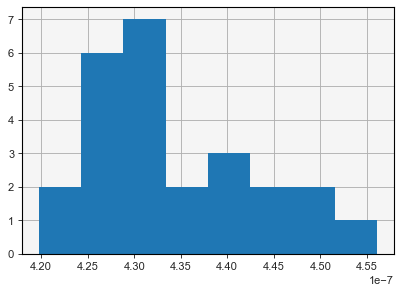

In [ ]:
count = 0
area = []
mp.figure()
for times, datas in zip(time_cut_data_sets[0], trans_corrected[0]): 
    area.append(simpson(datas, times))

mp.hist(area, 8)

4.3986184191951015e-07
4.326357451274158e-07
4.3252721734590675e-07
4.315063383119146e-07
4.289785948402262e-07
4.22693987865881e-07
4.272942190921826e-07
4.318046720356171e-07
4.3027966907414347e-07
4.4757713752329625e-07
4.28065909365535e-07
4.392333864415445e-07
4.2472924298786273e-07
4.327567822415258e-07
4.4541421351283906e-07
4.252490415474375e-07
4.340137042079095e-07
4.462996182895263e-07
4.248818437972103e-07
4.4867384305000694e-07
4.197335639039845e-07
4.263497699414379e-07
4.3853293168926527e-07
4.562009524603485e-07
4.3425452721725577e-07


C:\Users\keena\AppData\Local\Temp\ipykernel_9012\2074741846.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  mp.figure()


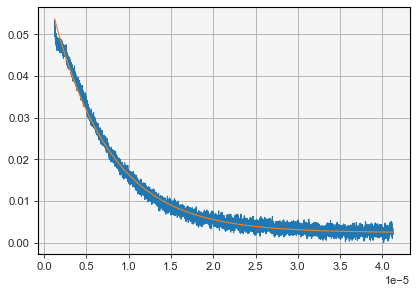

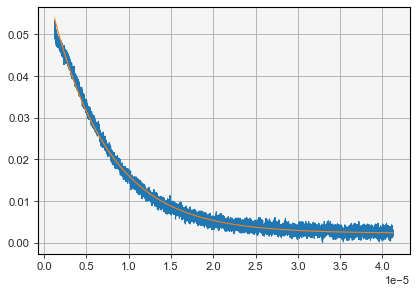

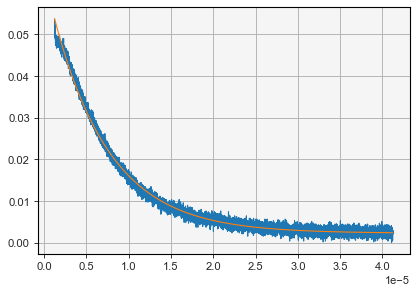

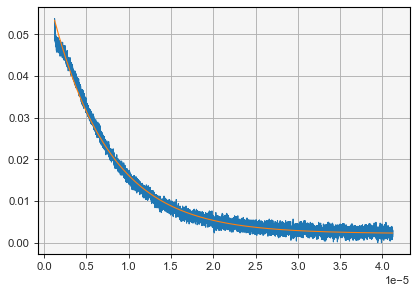

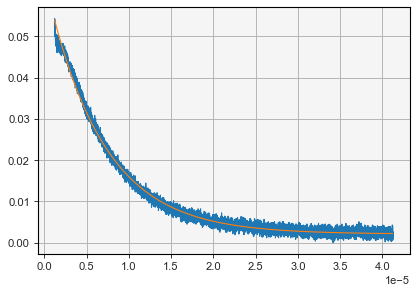

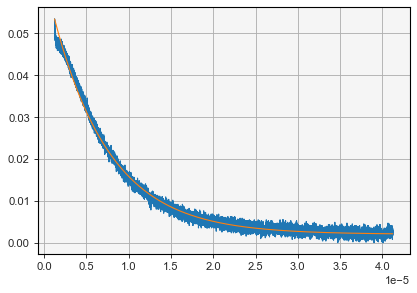

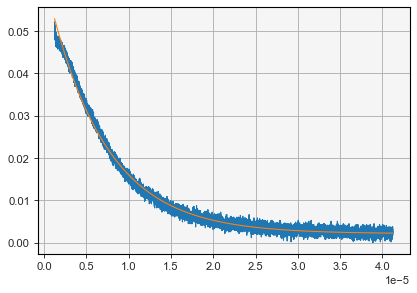

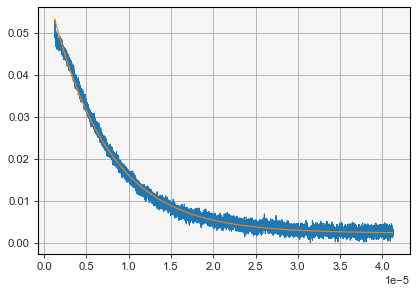

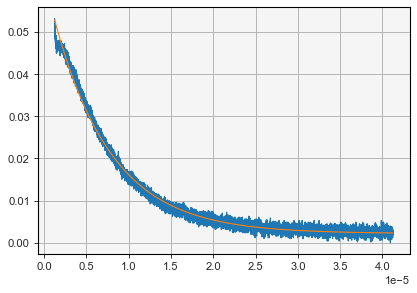

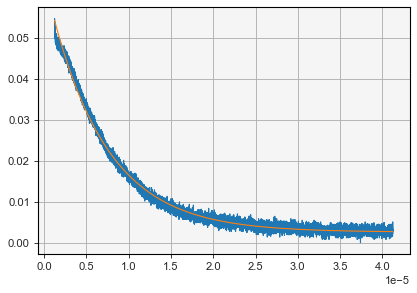

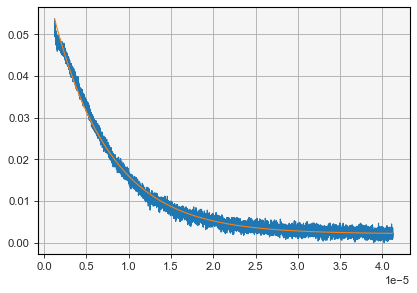

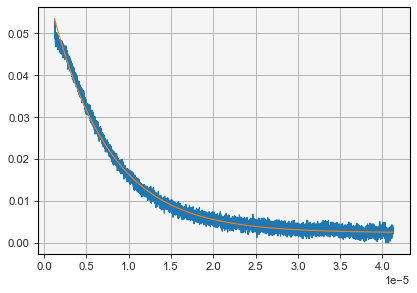

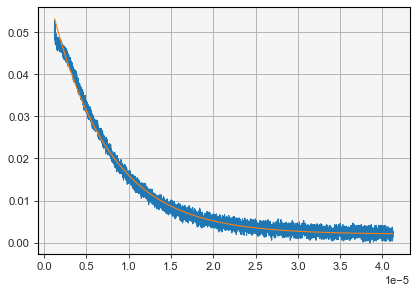

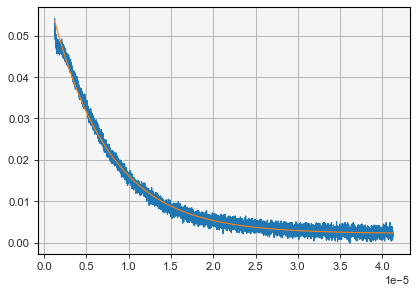

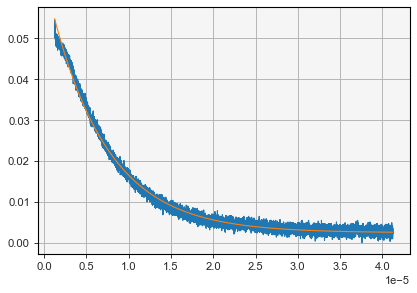

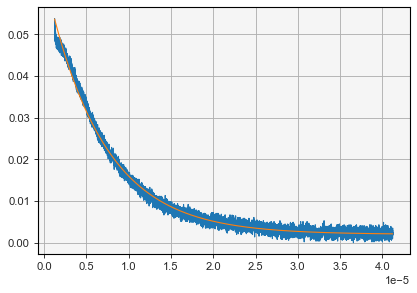

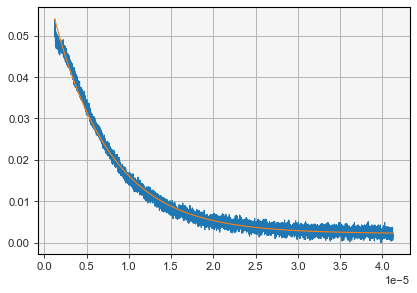

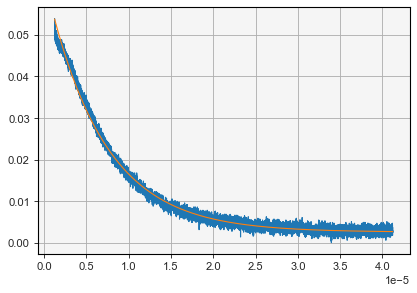

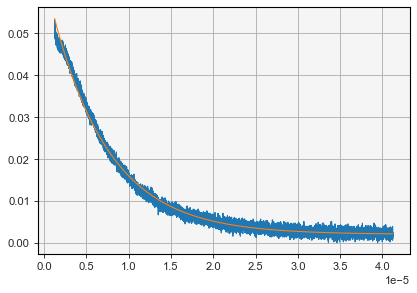

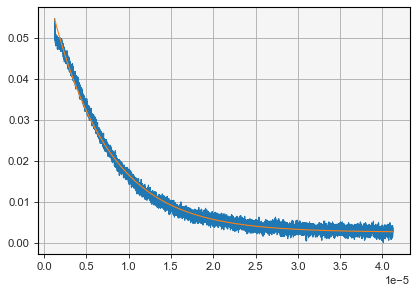

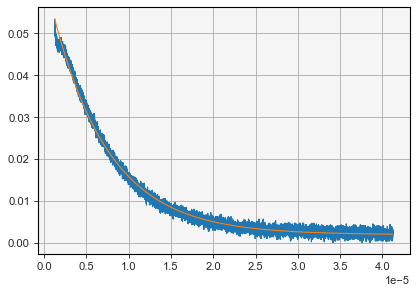

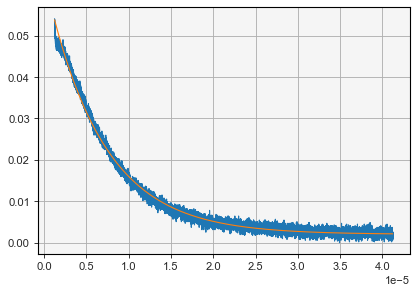

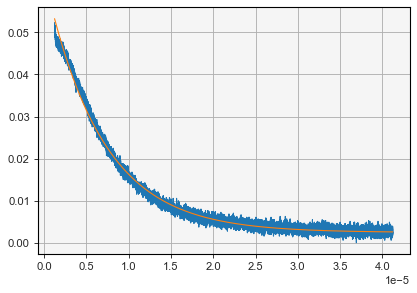

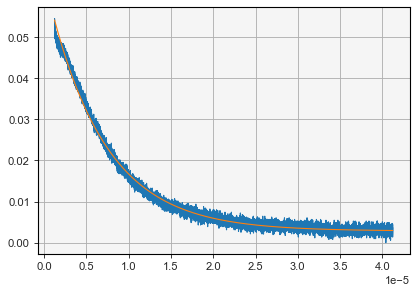

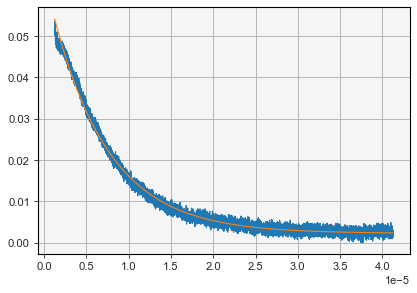

In [ ]:
from scipy.integrate import simpson
#area = 0
count = 0


for times, datas in zip(time_cut_data_sets[0], fit_data_sets[0]): 
    area = simpson(datas, times)
    mp.figure()
    mp.plot(times, trans_corrected[0][count])
    mp.plot(times, datas)
    print(area)
    count += 1



##### Fit To Corrected Data

        Fit to double exponential decay and return array of fit params and errors
      

In [ ]:
# zip data together for list comprehension
zipped_data = zip(time_cut_lists, trans_corrected, list_of_maxs, ref_max_list, list_of_mins, ref_fall_times)
fit_corrected = [ff.fit_dbl_exp_decay(time, trans, params=(0.3*max_val, ref_max, guess_T1, min_val, fall_time)) for time, trans, max_val, ref_max, min_val, fall_time in zipped_data]
# loop over corrected transmitted data - fit and plot data
for idx, time in enumerate(time_cut_lists):
    print(idx)

    fig, ax = mp.subplots(nrows=1, ncols=2)
    
    ax[0].set_title('Fluorescence Fit')
    ax[0].plot(time, trans_corrected[idx], color='blue', alpha=0.5, label='Exp. Data')
    ax[0].plot(time, ff.dbl_exp_decay(np.array(time), *fit_corrected[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[0].ticklabel_format(axis='both', style='sci', scilimits=(0,0), useMathText = True)
    ax[0].legend()
    
    ax[1].set_title('Log Scale Fit')
    ax[1].plot(time, trans_corrected[idx], color='blue', alpha=0.5, label='Exp. Data')
    ax[1].plot(time, ff.dbl_exp_decay(np.array(time), *fit_corrected[idx][0]), color='orange', linestyle='--', alpha=1, label='Fit')
    ax[1].set_yscale('log')
    ax[1].legend()
    print('Fit Params data[{0}]:'.format(idx))
    print("I01 : {0:2.2f} mV, I02 : {1:2.2f} mV, T11 : {2:2.2f} us, T12 : {3:2.2f} us, Y0 : {4:2.2f} mV".format(*fit_corrected[idx][0]*1E6))
    print('Fit Error data[{0}]:'.format(idx))
    print("dI01 : {0:2.2f} mV, dI02 : {1:2.2f} mV, dT11 : {2:2.2f} us, dT12 : {3:2.2f} us, dY0 : {4:2.2f} mV \n".format(*fit_corrected[idx][1]*1E6))

NameError: name 'time_cut_lists' is not defined

In [ ]:
fit_calc = []